<a href="https://colab.research.google.com/github/araujobma/DisasterTweetsCompetition/blob/main/TwitterDisasterNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exploratory Data Analysis (EDA)

This notebook is for the 4th assignment of the "Introduction to Deep Learning" course by UC Boulder on Coursera.

**Goal:** This notebook demonstrates one approach to the Kaggle competition "Natural Language Processing with Disaster Tweets"(https://www.kaggle.com/competitions/nlp-getting-started). The goal of the competition is to predict whether tweets are about real disasters or not.  

**Dataset:** The dataset contains 10,873 tweets, each with 5 columns. The most important columns are 'text' (the tweet content) and 'target' (indicating whether the tweet is about a real disaster).

In [ ]:
#Define some environment variables to sownload the dataset from kaggle
from google.colab import userdata
import pandas as pd
import os

os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

In [ ]:
#Download the dataset
!pip install -qU install kaggle
!kaggle competitions download -c nlp-getting-started

ERROR: Could not find a version that satisfies the requirement install (from versions: none)
ERROR: No matching distribution found for install
nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#Dataset extraction
import zipfile
with zipfile.ZipFile('nlp-getting-started.zip', 'r') as zip_ref:
    zip_ref.extractall()


In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
#View proportion of not null keyword and locations to the entire train dataset
train_size = train_df.shape[0]

notnul_keyword = train_df['keyword'].notnull().sum() / train_size
notnul_location = train_df['location'].notnull().sum() / train_size


Plotting the proportion of not null keyword and locations it is obseverded the number of data points with null keywords is almost 0, so we can use the keyword field as one of the input features to the model.

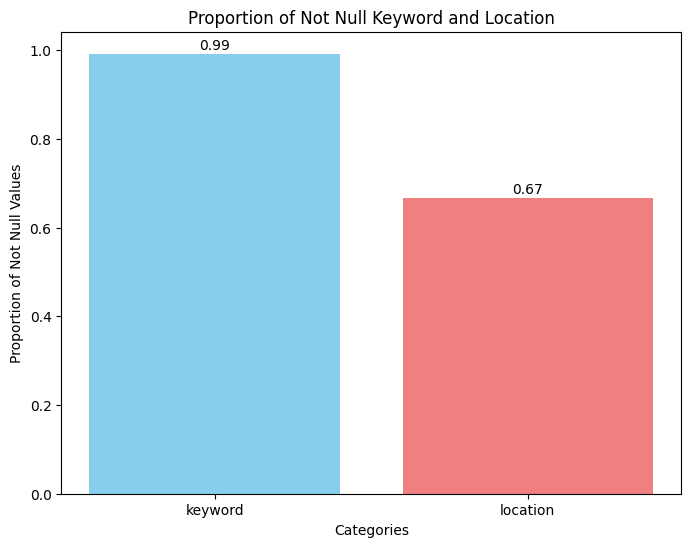

In [ ]:
import matplotlib.pyplot as plt

# Data for the plot
categories = ['keyword', 'location']
proportions = [notnul_keyword, notnul_location]

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(categories, proportions, color=['skyblue', 'lightcoral'])

# Add labels and title
plt.xlabel("Categories")
plt.ylabel("Proportion of Not Null Values")
plt.title("Proportion of Not Null Keyword and Location")

# Add value labels above each bar
for i, v in enumerate(proportions):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center')

# Show the plot
plt.show()

In [ ]:
uniq_keyword = train_df['keyword'].unique()
#size of unique keyword
print("Number of unique keywords:", len(uniq_keyword))
#transform nan to empty string
for idx,w in enumerate(uniq_keyword):

  if pd.isna(w):
    uniq_keyword[idx] = ''
print(uniq_keyword[0:10],'...')

Number of unique keywords: 222
['' 'ablaze' 'accident' 'aftershock' 'airplane%20accident' 'ambulance'
 'annihilated' 'annihilation' 'apocalypse' 'armageddon'] ...


After getting the unique keywords(categories),we transform the keywords to a one hot encoded vector to use as an input to our model.

In [ ]:
import numpy as np

def keyword_to_onehot(keyword, unique_keywords):
  """Transforms a keyword into a one-hot encoded vector.

  Args:
    keyword: The keyword to encode.
    unique_keywords: A list of unique keywords.

  Returns:
    A one-hot encoded vector representing the keyword.
    Returns None if the keyword is not found in unique_keywords.
  """
  try:
    index = np.where(unique_keywords == keyword)[0][0]
    onehot = np.zeros(len(unique_keywords))
    onehot[index] = 1
    return onehot
  except IndexError:
    return np.zeros(len(unique_keywords))


In [ ]:
#apply onehot encoding to keyword column
train_df['keyword_onehot'] = train_df['keyword'].apply(lambda x: keyword_to_onehot(x, uniq_keyword))
test_df['keyword_onehot'] = test_df['keyword'].apply(lambda x: keyword_to_onehot(x, uniq_keyword))

Extracting the max number of words in all tweets(text column)
to determine a max number  of tokens(subwords).
This is our

In [ ]:
#max length of text
train_df['len_text'] = train_df['text'].apply(lambda x: len(x.split()))
print(train_df['len_text'].max())
#max length of summary
test_df['len_text'] = test_df['text'].apply(lambda x: len(x.split()))
print(test_df['len_text'].max())

31
31


## Creating embeddings from text
This step is requred to transform the tweet texts to an embedding vector that is adequate to pass as a feature to our model.

In [ ]:
#we define the max number of tokens to ~ the double of max words
max_tokens = 64

In [ ]:
#This is necessary for keras transformers compability
!pip install -qU transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 26.2 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer, TFBertModel

In [ ]:
#Using the pretrained BERT model to generate the embeddings
tokenizer = BertTokenizer.from_pretrained("google/bert_uncased_L-4_H-512_A-8")
bert_encoder = TFBertModel.from_pretrained("google/bert_uncased_L-4_H-512_A-8", from_pt=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/116M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [ ]:
import tensorflow as tf
from tqdm.rich import tqdm
tf.__version__

'2.17.1'

In [ ]:
def embed_text(text, tokenizer, encoder, max_tokens=64):
  """Encodes text using BERT and returns the embedding.

  Args:
    text: The text to encode.
    tokenizer: The BERT tokenizer.
    encoder: The BERT encoder.
    max_tokens: The maximum number of tokens to consider.

  Returns:
    A NumPy array representing the text embedding.
    Returns None if an error occurs during encoding.
  """
  encoded_input = tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_tokens,
    padding='max_length',
    truncation=True,
    return_tensors="tf",
    return_attention_mask=True,
  )

  input_ids = encoded_input["input_ids"]
  attention_mask = encoded_input["attention_mask"]

  embedding = encoder(input_ids, attention_mask=attention_mask)[0][:, 0, :]
  return embedding


In [ ]:
#original text
print(train_df.iloc[1]['text'], "- Label: ", train_df.iloc[1]['target'])
#sample of embedding
embedding0 = embed_text(train_df.iloc[1]['text'], tokenizer, bert_encoder, max_tokens)
print("\nEmbedding representation:")
print("dimension:",embedding0.shape)
print(embedding0[0][0:10])

Forest fire near La Ronge Sask. Canada - Label:  1

Embedding representation:
dimension: (1, 512)
tf.Tensor(
[ 0.9074336  -0.23041317  0.18292159  0.13967937  0.95024157 -0.11791632
  0.4992225  -1.0760518   0.14648584  1.4460257 ], shape=(10,), dtype=float32)


In [ ]:
#create row text embedding
train_df['text_embedding'] = None
for idx, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
  train_df.at[idx, 'text_embedding'] = embed_text(row['text'], tokenizer, encoder, max_tokens)

Output()

<ipython-input-19-6af6d6489733>:3: TqdmExperimentalWarning: rich is experimental/alpha
  for idx, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):


In [ ]:
test_df['text_embedding'] = None
for idx, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
  test_df.at[idx, 'text_embedding'] = embed_text(row['text'], tokenizer, encoder, max_tokens)

In [ ]:
train_df.to_csv('train_df_features.csv', index=False)
test_df.to_csv('test_df_features.csv', index=False)

In [ ]:
import numpy as np
#saving embeddings for use later and skip the previous step of generating enbeddings

embeddings = np.array(train_df['text_embedding'].to_list())
np.save('train_embeddings.npy', embeddings)

embeddings_test = np.array(test_df['text_embedding'].to_list())
np.save('test_embeddings.npy', embeddings_test)

In [ ]:
#Load the embeddings if already saved to a file


#Verification
train_embeddings = np.load('train_embeddings.npy', allow_pickle=True)
#to tf tensor
train_embeddings_tf = tf.convert_to_tensor(train_embeddings)
del train_embeddings
print(train_embeddings_tf.shape)
print(train_embeddings_tf[0][0][0:10])



#Verification
test_embeddings = np.load('test_embeddings.npy', allow_pickle=True)
#to tf tensor
test_embeddings_tf = tf.convert_to_tensor(test_embeddings)
del test_embeddings
print(test_embeddings_tf.shape)
print(test_embeddings_tf[0][0][0:10])

(7613, 1, 512)
tf.Tensor(
[ 0.042609   -0.552446   -0.39512634 -2.0395823  -1.2966131   1.0808511
 -0.21634126 -0.05564177  0.23748732  0.26073593], shape=(10,), dtype=float32)
(3263, 1, 512)
tf.Tensor(
[ 0.02875551 -0.4657723   0.95861757 -0.07509625  0.23833399 -1.0057863
  1.186554   -0.00167938  0.33177075  1.6366664 ], shape=(10,), dtype=float32)


In [ ]:
## Creating and tuning the model

In [ ]:
#import layers
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU, Flatten, concatenate

# Define the layers of classification layer
dense_512 = Dense(512)
dropout_1 = Dropout(0.2)
leaky_relu_1 = LeakyReLU()
dense_64_embedding = Dense(64)
dropout_2 = Dropout(0.2)
leaky_relu_2 = LeakyReLU()
flatten_layer = Flatten()

dense_64_keyword = Dense(64, activation='relu')
dropout_3 = Dropout(0.2)
dense_32_keyword = Dense(32, activation='relu')
dropout_4 = Dropout(0.2)
dense_10_keyword = Dense(10, activation='relu')

concatenate_layer = concatenate

dense_64_final = Dense(64, activation='relu')
dense_1_final = Dense(1, activation='sigmoid')

def classification_layer(embedding_input, keyword_input):
    embedding_input = Flatten()(embedding_input)
    #Process the embeddings using the pre-defined layers
    y1 = dense_512(embedding_input)
    y1 = dropout_1(y1)
    y1 = leaky_relu_1(y1)
    y1 = dense_64_embedding(y1)
    y1 = dropout_2(y1)
    y1 = leaky_relu_2(y1)
    y1 = flatten_layer(y1)

    # Process the keywords using the pre-defined layers
    y2 = dense_64_keyword(keyword_input)
    y2 = dropout_3(y2)
    y2 = dense_32_keyword(y2)
    y2 = dropout_4(y2)
    y2 = dense_10_keyword(y2)

    # Combine the processed embeddings and keywords
    combined = concatenate_layer([y1, y2])

    # Add dense layers for classification using pre-defined layers
    z = dense_64_final(combined)
    classification_output = dense_1_final(z)

    return classification_output

embedding_input = Input(shape=(512,))
keyword_input = Input(shape=(len(uniq_keyword),))

classification_output = classification_layer(embedding_input, keyword_input)

# Create and compile the model
model = tf.keras.Model(inputs=[embedding_input, keyword_input], outputs=classification_output)
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001) ,
              loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:


# Train the model
history = model.fit(
          [tf.squeeze(train_embeddings_tf, axis=1),  # Squeeze the extra dimension
           tf.convert_to_tensor(np.stack(train_df['keyword_onehot'].to_numpy()))],
          tf.convert_to_tensor(np.stack(train_df['target'].to_numpy())),
          validation_split=0.15,
          epochs=10,
          batch_size=16)




In [ ]:
#Fine tuning the model
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.1 MB/s eta 0:00:00


In [ ]:
 #unzip /content/input_embedding_model.zip contents tp /contrnt/my_dir
 !unzip /content/drive/MyDrive/input_embedding_model.zip

Based on previous model we create tuning parameters to search for the best hyperparameters that increase the model performance

In [ ]:
import keras_tuner as kt

def build_model(hp):
  # Define the hyperparameter search space
  hp_units_1_emb = hp.Int('units_1', min_value=256, max_value=1024, step=256)
  hp_dropout_1_emb = hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)
  hp_units_2_emb = hp.Int('units_2', min_value=32, max_value=256, step=32)
  hp_dropout_2_emb = hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)


  dense_1_emb = Dense(hp_units_1_emb)
  dropout_1_emb = Dropout(hp_dropout_1_emb)
  leaky_relu_1_emb = LeakyReLU()
  dense_2_emb = Dense(hp_units_2_emb)
  dropout_2_emb = Dropout(hp_dropout_2_emb)
  leaky_relu_2_emb = LeakyReLU()
  flatten_layer_emb = Flatten()

  hp_units_1_keyword = hp.Int('units_3', min_value=256, max_value=1024, step=256)
  hp_dropout_1_keyword = hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)
  hp_units_2_keyword = hp.Int('units_4', min_value=32, max_value=256, step=32)
  hp_dropout_2_keyword = hp.Float('dropout_4', min_value=0.1, max_value=0.5, step=0.1)
  hp_units_3_keyword = hp.Int('units_5', min_value=16, max_value=256, step=32)

  dense_1_keyword = Dense(hp_units_1_keyword)
  dropout_1_keyword = Dropout(hp_dropout_1_keyword)
  leaky_relu_1_keyword = LeakyReLU()
  dense_2_keyword = Dense(hp_units_2_keyword)
  dropout_2_keyword = Dropout(hp_dropout_2_keyword)
  leaky_relu_2_keyword = LeakyReLU()
  dense_3_keyword = Dense(hp_units_3_keyword)

  dense_32_final = Dense(32, activation='relu')
  dense_1_final = Dense(1, activation='sigmoid')

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  def classification_layer(embedding_input, keyword_input):
    embedding_input = Flatten()(embedding_input)
    #Process the embeddings using the pre-defined layers
    y1 = dense_1_emb(embedding_input)
    y1 = dropout_1_emb(y1)
    y1 = leaky_relu_1_emb(y1)
    y1 = dense_2_emb(y1)
    y1 = dropout_2_emb(y1)
    y1 = leaky_relu_2_emb(y1)
    y1 = flatten_layer_emb(y1)

    #process keyword input
    y2 = dense_1_keyword(keyword_input)
    y2 = dropout_1_keyword(y2)
    y2 = leaky_relu_1_keyword(y2)
    y2 = dense_2_keyword(y2)
    y2 = dropout_2_keyword(y2)
    y2 = leaky_relu_2_keyword(y2)
    y2 = dense_3_keyword(y2)

    combined = concatenate([y1, y2])

    z = dense_32_final(combined)
    classification_output = dense_1_final(z)

    return classification_output


  embedding_input = Input(shape=(512,))
  keyword_input = Input(shape=(len(uniq_keyword),))
  classification_output = classification_layer(embedding_input, keyword_input)
  model = tf.keras.Model(inputs=[embedding_input, keyword_input], outputs=classification_output)
  model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=hp_learning_rate),
                loss='binary_crossentropy', metrics=['accuracy'])
  return model

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='./',
    project_name='input_embedding_model'
)



Reloading Tuner from ./input_embedding_model/tuner0.json


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(
    [tf.squeeze(train_embeddings_tf, axis=1), tf.convert_to_tensor(np.stack(train_df['keyword_onehot'].to_numpy()))],
    tf.convert_to_tensor(np.stack(train_df['target'].to_numpy())),
    validation_split=0.10,
    epochs=10,
    batch_size=16,
    callbacks=[callback]
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

In [ ]:
# Now we get the best model from the tuning step
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_classifier_model = tuner.hypermodel.build(best_hps)
train_keywords = tf.convert_to_tensor(np.stack(train_df['keyword_onehot'].to_numpy()))

In [ ]:

#Retrain the best model on the full dataset without validation split
history = best_classifier_model.fit(
    [tf.squeeze(train_embeddings_tf, axis=1),
     train_keywords],
    tf.convert_to_tensor(np.stack(train_df['target'].to_numpy())),
    epochs=5,
    batch_size=16,
    shuffle=True
)


Epoch 1/5
476/476 [==============================] - 3s 2ms/step - loss: 0.5676 - accuracy: 0.7127
Epoch 2/5
476/476 [==============================] - 1s 2ms/step - loss: 0.4817 - accuracy: 0.7823
Epoch 3/5
476/476 [==============================] - 1s 2ms/step - loss: 0.4506 - accuracy: 0.7984
Epoch 4/5
476/476 [==============================] - 1s 2ms/step - loss: 0.4185 - accuracy: 0.8132
Epoch 5/5
476/476 [==============================] - 1s 2ms/step - loss: 0.4058 - accuracy: 0.8235


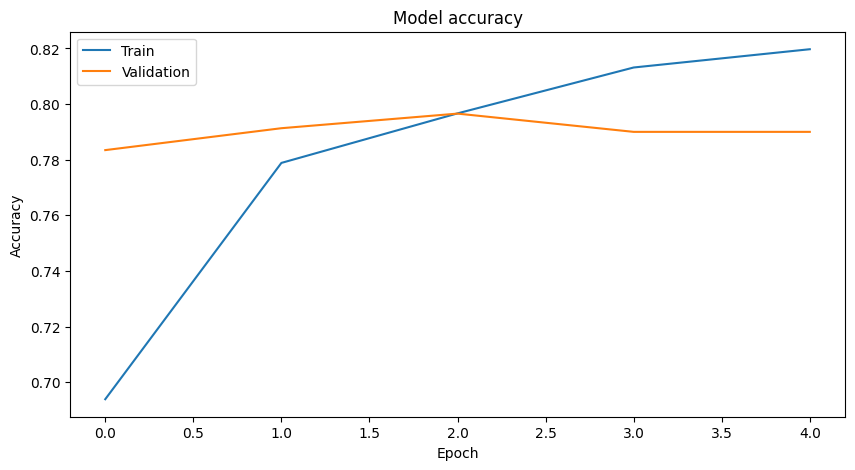

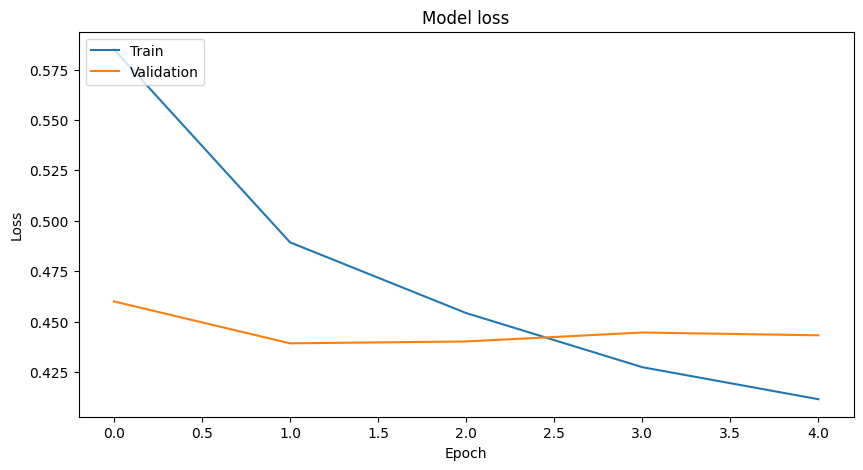

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Example prediction (replace with actual test data)
test_embeddings = np.load('test_embeddings.npy', allow_pickle=True)
test_keywords = np.array(test_df['keyword_onehot'].to_list())
test_embeddings_tf = tf.convert_to_tensor(test_embeddings)  # Convert to tensor
test_embeddings_tf = tf.squeeze(test_embeddings_tf, axis=1) # Remove extra dimension

predictions = best_model.predict([test_embeddings_tf, test_keywords])

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
# Create a DataFrame with 'id' and 'target' columns
submission_df = pd.DataFrame({'id': test_df['id'], 'target': np.round(predictions).astype(int).flatten()})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission_disaster.csv', index=False)

In [ ]:
# tokenizer = BertTokenizer.from_pretrained("google/bert_uncased_L-4_H-512_A-8")
# train_df['tokenized_text'] = train_df['text'].apply(lambda x: tokenizer.encode_plus(x, add_special_tokens=True,
#                                                                                     max_length=max_tokens, padding='max_length',
#                                                                                     truncation=True,return_tensors="tf",
#                                                                                     return_attention_mask=True))

In [ ]:
# train_df['input_ids'] = train_df['tokenized_text'].apply(lambda x: x['input_ids'].numpy().squeeze(axis=0))  # Squeeze the extra dimension
# train_df['attention_mask'] = train_df['tokenized_text'].apply(lambda x: x['attention_mask'].numpy().squeeze(axis=0)) # Squeeze the extra dimension



# input_ids = tf.convert_to_tensor(np.stack(train_df['input_ids'].to_numpy()))
# attention_mask = tf.convert_to_tensor(np.stack(train_df['attention_mask'].to_numpy()))


In [ ]:
# train_target = tf.convert_to_tensor(np.stack(train_df['target'].to_numpy()))
# train_keywords = tf.convert_to_tensor(np.stack(train_df['keyword_onehot'].to_numpy()))

## Fine tunning BERT
In this part we are going to use the previous classifier and fine tune the BERT model to achieve better results



In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*"
!pip install "tf-models-official==2.13.*"

  Using cached tf_models_official-2.13.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached sacrebleu-2.4.3-py3-none-any.whl.metadata (51 kB)
  Using cached seqeval-1.2.2.tar.gz (43 kB)
  Preparing metadata (setup.py) ... done
  Using cached tensorflow_model_optimization-0.8.0-py2.py3-none-any.whl.metadata (904 bytes)
  Using cached portalocker-3.0.0-py3-none-any.whl.metadata (8.5 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
Using cached tf_models_official-2.13.2-py2.py3-none-any.whl (2.6 MB)
Using cached tensorflow_model_optimization-0.8.0-py2.py3-none-any.whl (242 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 9.7 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=8c876611df54db67d916c9ab7e84184f2275b38b0af280415589b61d86058f5d
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

import numpy as np
import matplotlib.pyplot as plt



In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
def make_bert_preprocess_model(sentence_features, seq_length=64):
  """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: a list with the names of string-valued features.
    seq_length: an integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]

  # Tokenize the text to word pieces.
  bert_preprocess = hub.load(tfhub_handle_preprocess)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]


  # Pack inputs. The details (start/end token ids, dict of output tensors)
  # are model-dependent, so this gets loaded from the SavedModel.
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(segments)
  return tf.keras.Model(input_segments, model_inputs)

In [ ]:
text_preprocess_model = make_bert_preprocess_model(['input_preprocessed_text'])
test_text = [np.array(['some random test sentence'])]
text_preprocessed = text_preprocess_model(test_text)

print('Keys           : ', list(text_preprocessed.keys()))
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Keys           :  ['input_type_ids', 'input_mask', 'input_word_ids']
Shape Word Ids :  (1, 64)
Word Ids       :  tf.Tensor(
[ 101 2070 6721 3231 6251  102    0    0    0    0    0    0    0    0
    0    0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 64)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 64)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


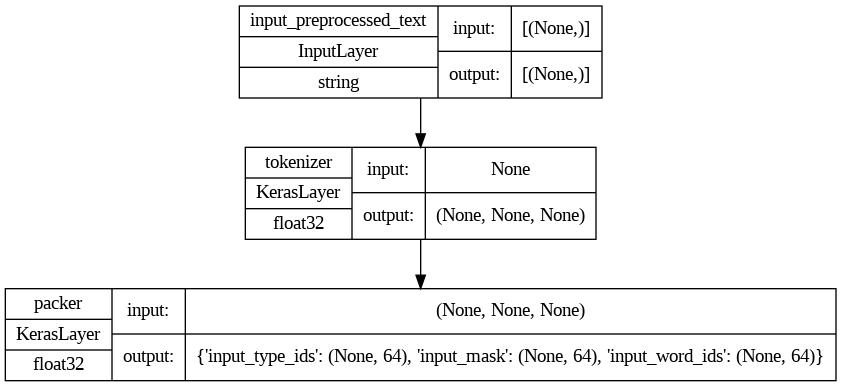

In [ ]:
tf.keras.utils.plot_model(text_preprocess_model, show_shapes=True, show_dtype=True)

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder, trainable=True)
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.9918165   0.7630664  -0.2187894   0.27431926 -0.40091383  0.78194207
  0.99362737 -0.99301076 -0.61936057 -0.95493037 -0.4580887  -0.9885139 ]
Sequence Outputs Shape:(1, 64, 512)
Sequence Outputs Values:[[-2.9771143e-01  6.4548798e-02  3.0547163e-02 ... -7.8205311e-01
   1.0129344e+00  1.2293499e+00]
 [-9.3373477e-01  1.1666274e+00 -1.3923870e-01 ... -4.6837592e-01
  -2.2441384e-01  9.0059048e-01]
 [-1.3425958e+00  6.9638526e-01  6.5501511e-02 ... -7.0271611e-01
   4.0931273e-01  1.7403001e+00]
 ...
 [-3.0333886e-01  3.5508168e-01 -2.4021789e-01 ... -9.6186757e-02
   1.1297441e+00  5.9780836e-01]
 [ 4.0511250e-02  2.0318532e-01 -4.2578954e-01 ...  6.5222360e-02
   1.2060835e+00  5.7669806e-01]
 [-4.0159339e-01  2.1089827e-01 -9.2172042e-02 ...  1.2062639e-03
   8.7390256e-01  6.1164039e-01]]


In [ ]:

#This model is a composition of the bert model for processing the input text and
#the previous generated classifier

def build_binary_classifier_with_bert(encoder, classifier_model):
    class BinaryTextClassifier(tf.keras.Model):
        def __init__(self, encoder, classifier_model):
            super(BinaryTextClassifier, self).__init__()
            self.encoder = encoder
            self.classifier_model = classifier_model

        def call(self, inputs):
            preprocessed_text, keyword_input = inputs
            encoder_outputs = self.encoder(preprocessed_text)
            pooled_output = encoder_outputs["pooled_output"]

            # Get batch size dynamically from pooled_output
            batch_size = tf.shape(pooled_output)[0]
            # Reshape keyword_input to (batch_size, 222)
            keyword_input = tf.reshape(keyword_input, (batch_size, 222))

            x = self.classifier_model([pooled_output, keyword_input])
            return x


    return BinaryTextClassifier(encoder, best_classifier_model)

In [ ]:
test_row = train_df.iloc[1]
text_preprocessed = text_preprocess_model([np.array([test_row['text']]).T])
keyword_input = test_row['keyword_onehot']

bert_classifier_model = build_binary_classifier_with_bert(bert_model, best_classifier_model)

#Here we freeze the classifier model to only train the BERT model
bert_classifier_model.classifier_model.trainable = False

raw_result = bert_classifier_model([text_preprocessed, keyword_input])
print("Shape of the output tensor:", raw_result.shape)
raw_result


Shape of the output tensor: (1, 1)


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49377778]], dtype=float32)>

In [ ]:
bert_classifier_model.summary()

Model: "binary_text_classifier_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  multiple                  28763649  
                                                                 
 model_4 (Functional)        (None, 1)                 243057    
                                                                 
Total params: 29006706 (110.65 MB)
Trainable params: 28763648 (109.72 MB)
Non-trainable params: 243058 (949.44 KB)
_________________________________________________________________


In [ ]:
bert_classifier_model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=5e-5),
                              loss='binary_crossentropy', metrics=['accuracy'])



In [ ]:
preprocessed_corpus = text_preprocess_model(train_df['text'])
train_keywords = tf.convert_to_tensor(np.stack(train_df['keyword_onehot'].to_numpy()))
train_target = tf.convert_to_tensor(np.stack(train_df['target'].to_numpy()))

bert_classifier_model.predict([preprocessed_corpus, train_keywords])

NameError: name 'bert_classifier_model' is not defined

In [ ]:
bert_classifier_model.fit([preprocessed_corpus, train_keywords], train_target, epochs=5, batch_size=16)

In [ ]:
# prompt: use keras tuner to create checkpoints. dont need to search hyperparameters

import tensorflow as tf

checkpoint_filepath = '/content/drive/MyDrive/checkpoint_bert_class'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
tf.debugging.set_log_device_placement(True)

history = bert_classifier_model.fit(
    [preprocessed_corpus, train_keywords],
    train_target,
    epochs=5,
    batch_size=16,
    validation_split=0.15,
    callbacks=[model_checkpoint_callback],
    shuffle=True)

Epoch 1/5
405/405 [==============================] - 136s 327ms/step - loss: 0.4509 - accuracy: 0.7954 - val_loss: 0.3948 - val_accuracy: 0.8380
Epoch 2/5
405/405 [==============================] - 130s 321ms/step - loss: 0.3633 - accuracy: 0.8493 - val_loss: 0.3902 - val_accuracy: 0.8231
Epoch 3/5
405/405 [==============================] - 129s 320ms/step - loss: 0.2940 - accuracy: 0.8855 - val_loss: 0.5131 - val_accuracy: 0.8012
Epoch 4/5
373/405 [==========================>...] - ETA: 9s - loss: 0.2034 - accuracy: 0.9224 

KeyboardInterrupt: 

In [ ]:
# prompt: User tuner hyperband to train a bert_classifier_model varying batch size and learning rate

import keras_tuner as kt


def build_model(hp):
    bert_model = hub.KerasLayer(tfhub_handle_encoder, trainable=True)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5, 5e-5])

    bert_classifier_model_tuned = build_binary_classifier_with_bert(bert_model, best_classifier_model)
    bert_classifier_model_tuned.classifier_model.trainable = True
    bert_classifier_model_tuned.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=hp_learning_rate),
                                        loss='binary_crossentropy', metrics=['accuracy'])

    return bert_classifier_model_tuned


In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='./drive/MyDrive',
    project_name='bert_classifier_hyperband_8_batch_full_training'
)


callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

tuner.search(
    [preprocessed_corpus, train_keywords],
    train_target,
    validation_split=0.15,
    epochs=5,
    batch_size=8,  # Use the hyperparameter
    callbacks=[callback]
)


Trial 5 Complete [00h 06m 04s]
val_accuracy: 0.5341506004333496

Best val_accuracy So Far: 0.7968476414680481
Total elapsed time: 00h 30m 29s


In [ ]:

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='./drive/MyDrive',
    project_name='bert_classifier_hyperband_8_batch_full_training'
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

# Build the model with the best hyperparameters
best_bert_classifier_model_8batchsize_full_training = tuner.hypermodel.build(best_hps)


# Compile the model with the best learning rate
best_bert_classifier_model_8batchsize_full_training.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=best_hps.get('learning_rate')),
                              loss='binary_crossentropy', metrics=['accuracy'])

# Train the best model with the best batch size
history = best_bert_classifier_model_8batchsize_full_training.fit(
    [preprocessed_corpus, train_keywords],
    train_target,
    epochs=3,
    batch_size=8,
    #validation_split=0.10,
    callbacks=[model_checkpoint_callback],
    shuffle=True)

In [ ]:
preprocessed_corpus_test = text_preprocess_model(test_df['text'])
train_keywords_test = tf.convert_to_tensor(np.stack(test_df['keyword_onehot'].to_numpy()))

# Use 'preprocessed_corpus' instead of 'test_embeddings_tf' for prediction
predictions = best_bert_classifier_model_8batchsize_full_training.predict([preprocessed_corpus_test, train_keywords_test])

# Create a DataFrame with 'id' and 'target' columns
submission_df = pd.DataFrame({'id': test_df['id'], 'target': np.round(predictions).astype(int).flatten()})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission_disaster.csv', index=False)

102/102 [==============================] - 15s 140ms/step


## Results/conclusion
The approach demonstrated in the notebook effectively utilizes text embeddings and keyword information to classify disaster-related tweets.
Hyperparameter tuning and BERT fine-tuning significantly contributed to model improvement.
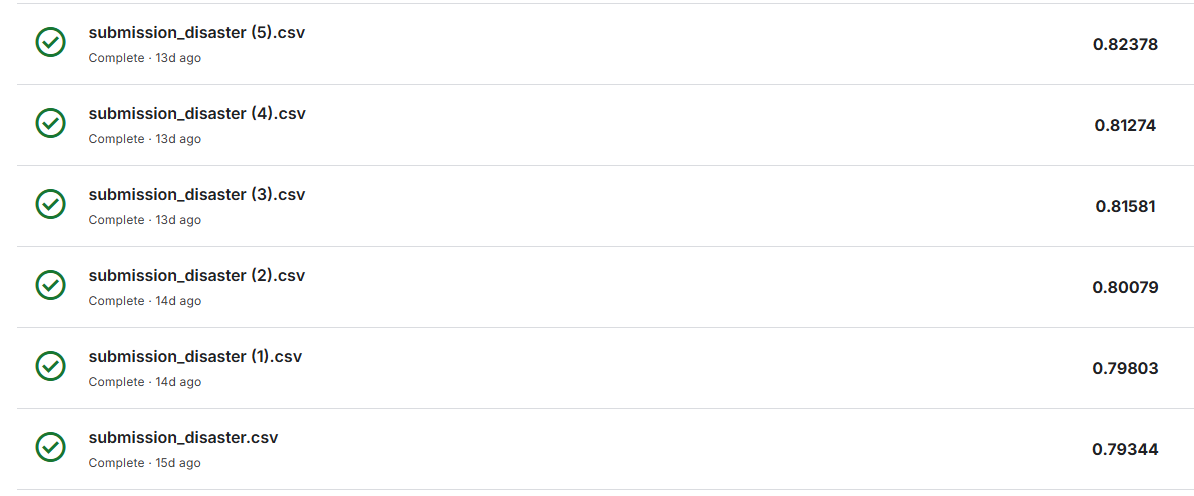

Further improvements could be explored by experimenting with different model architectures, data augmentation techniques, etc.

## References:

https://huggingface.co/docs/transformers/en/model_doc/bert

https://keras.io/examples/nlp/pretraining_BERT/

https://www.tensorflow.org/tfmodels/nlp/fine_tune_bert